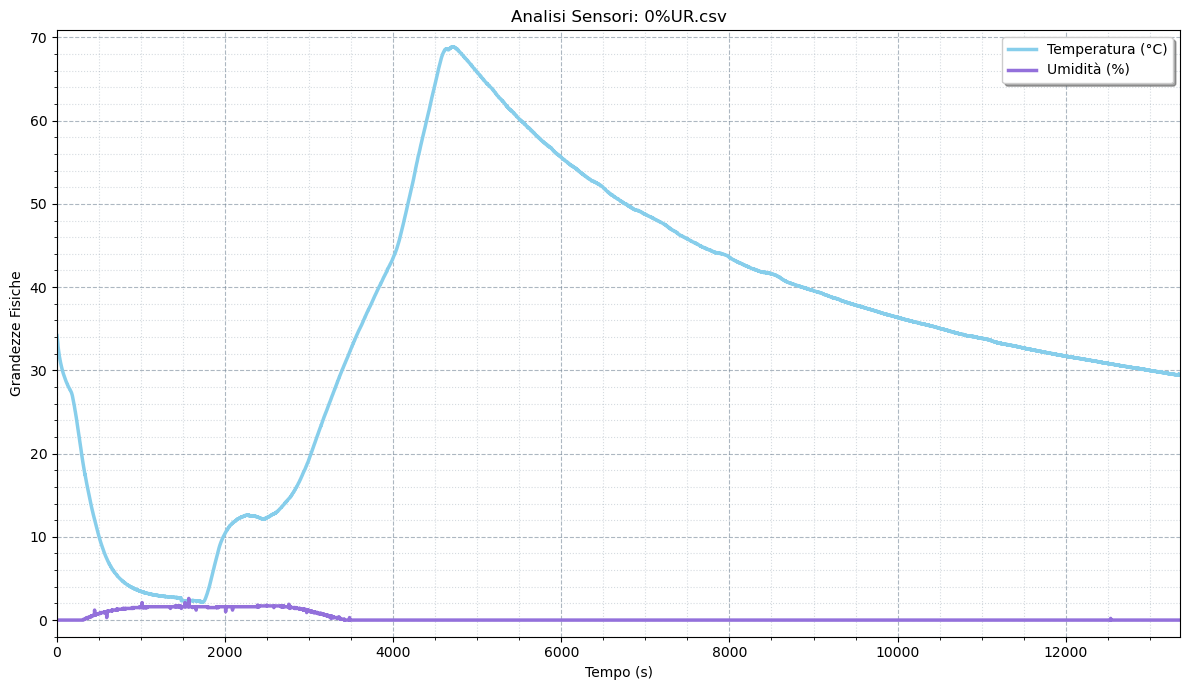

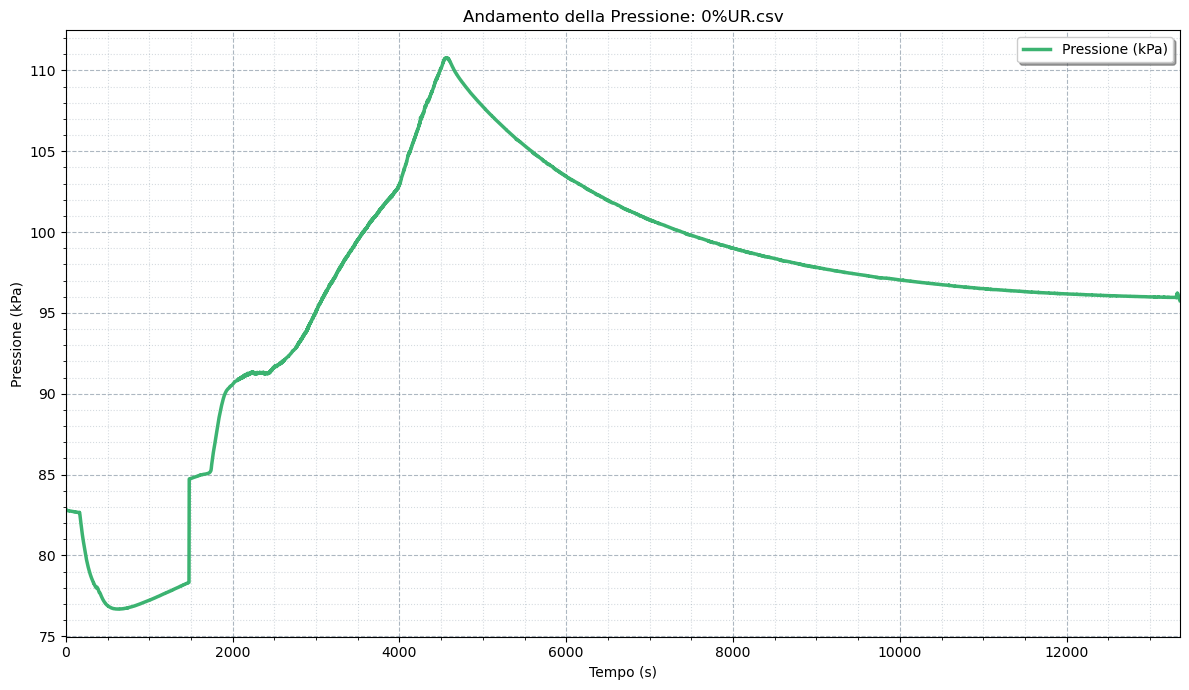

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configurazione Iniziale ---
FOLDER = '300ml'
FILENAME = '0%UR.csv'  # Cambia qui: 'frigo.csv' o 'forno.csv'
FILE_PATH = os.path.join(FOLDER, FILENAME)
STEP_TEMPORALE_S = 1.0  # Definire il passo temporale

# 1. Caricamento Dati
# Assumo che il file esista e sia caricabile, aggiungi header=None se necessario
if os.path.exists(FILE_PATH):
    df = pd.read_csv(FILE_PATH)
else:
    raise FileNotFoundError(f"Il file {FILE_PATH} non è stato trovato.")

# 2. Parsing e Pulizia
df.columns = ['Timestamp_Raw', 'Temp_K', 'Hum_Pct', 'Pres_kPa']

regex_num = r'(\d+\.?\d*)' 

df['Temperatura'] = df['Temp_K'].astype(str).str.extract(regex_num).astype(float) - 273.15
df['Umidita'] = df['Hum_Pct'].astype(str).str.extract(regex_num).astype(float)
df['Pressione'] = df['Pres_kPa'].astype(str).str.extract(regex_num).astype(float)
df.dropna(subset=['Temperatura', 'Umidita', 'Pressione'], inplace=True)

# 3. Creazione Asse Temporale Sintetico (Pre-filtraggio)
# Generato prima del taglio per mantenere la coerenza temporale assoluta
df['Tempo_Simulato_s'] = np.arange(len(df)) * STEP_TEMPORALE_S

# --- 3. Plotting: Temperatura e Umidità ---
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(df['Tempo_Simulato_s'], df['Temperatura'], 
         label='Temperatura (°C)', color='skyblue', linewidth=2.5)
ax1.plot(df['Tempo_Simulato_s'], df['Umidita'], 
         label='Umidità (%)', color='mediumpurple', linewidth=2.5)

# Limiti e Label ax1
vals = df[['Temperatura', 'Umidita']].values
if not df.empty:
    y_min, y_max = np.nanmin(vals), np.nanmax(vals)
    ax1.set_ylim(bottom=y_min - 2, top=y_max + 2)
    ax1.set_xlim(left=0, right=df['Tempo_Simulato_s'].max() + STEP_TEMPORALE_S)

ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Grandezze Fisiche')
ax1.set_title(f'Analisi Sensori: {FILENAME}')
ax1.grid(True, which='major', linestyle='--', alpha=0.6, color='#778899') 
ax1.minorticks_on()
ax1.grid(True, which='minor', linestyle=':', alpha=0.3, color='#778899')
ax1.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()

# --- 4. Plotting: Pressione ---
plt.figure(figsize=(12, 7))
plt.plot(df['Tempo_Simulato_s'], df['Pressione'], 
         label='Pressione (kPa)', color='mediumseagreen', linewidth=2.5)

if not df.empty:
    plt.xlim(left=0, right=df['Tempo_Simulato_s'].max() + STEP_TEMPORALE_S)

plt.xlabel('Tempo (s)')
plt.ylabel('Pressione (kPa)')
plt.title(f'Andamento della Pressione: {FILENAME}')
plt.grid(True, which='major', linestyle='--', alpha=0.6, color='#778899') 
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', alpha=0.3, color='#778899')
plt.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()


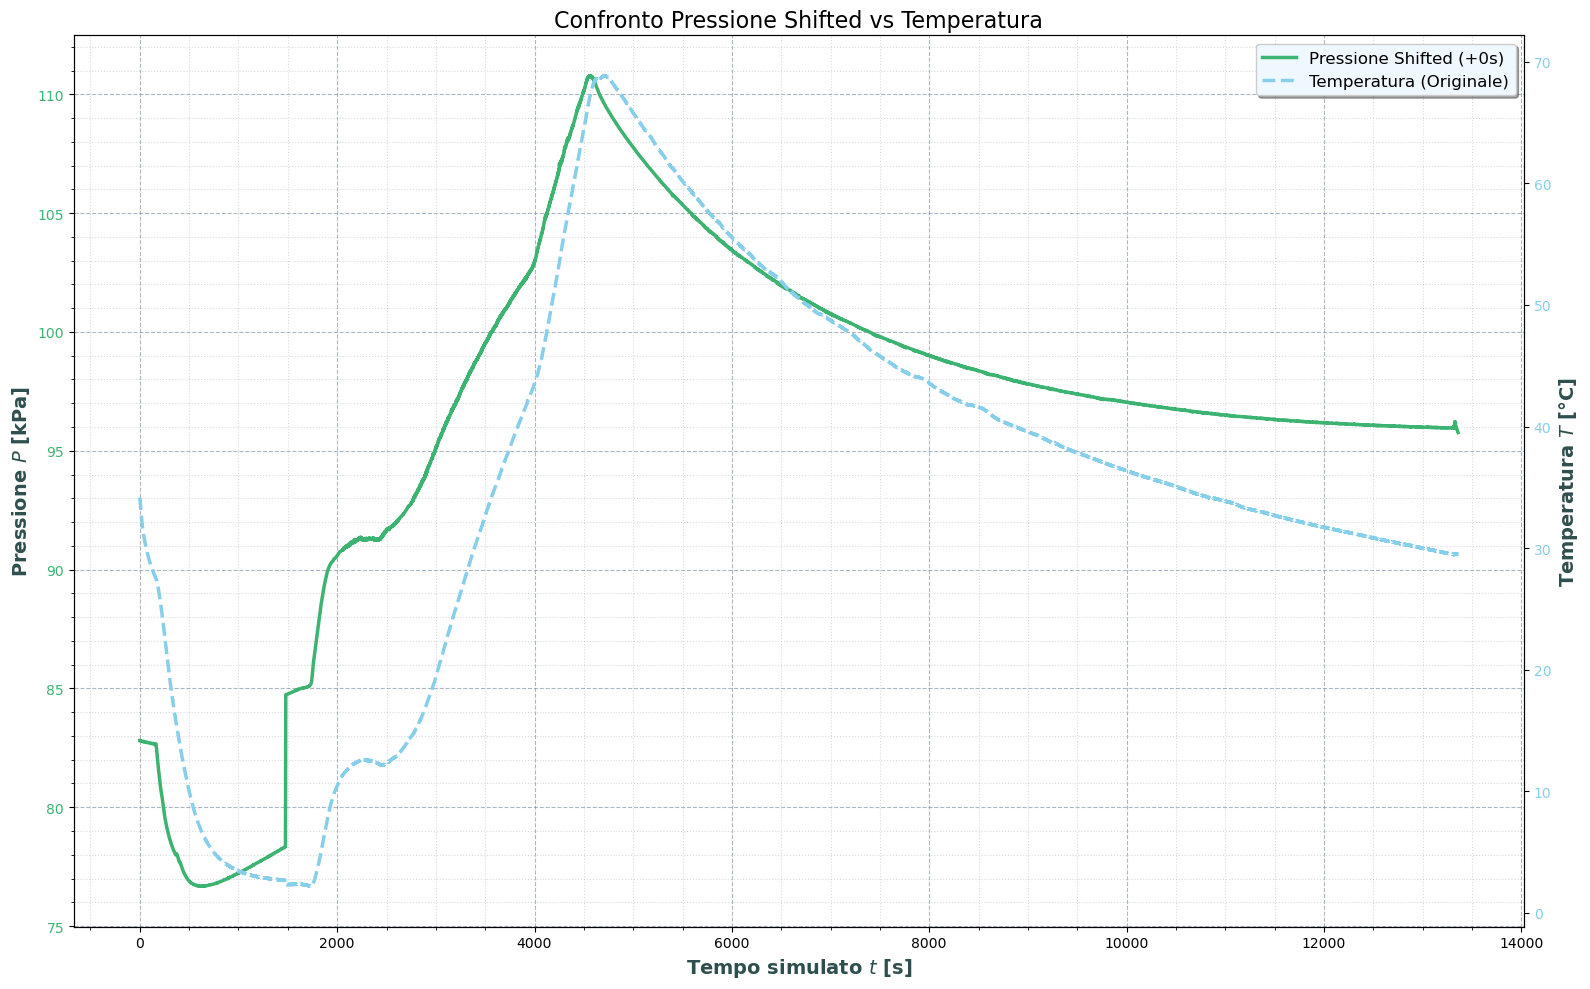

----------------------------------------
Tempo picco Pressione (Shifted): 4567.00 s
Tempo picco Temperatura (Orig):  4701.00 s
----------------------------------------


In [2]:
SHIFT_TEMPORALE_T = 0  # Secondi (POSITIVO = sposta in avanti/destra)
shift_steps = int(SHIFT_TEMPORALE_T / STEP_TEMPORALE_S)

# Applico lo shift: 
# Shift POSITIVO sposta i valori "giù" (avanti nel tempo). 
# I primi 'shift_steps' diventeranno NaN.
df['Pressione'] = df['Pressione'].shift(shift_steps)

# Pulizia: Rimuoviamo le righe dove lo shift ha creato buchi (i primi N secondi)
df_plot = df.dropna(subset=['Pressione', 'Temperatura'])

fig, ax1 = plt.subplots(figsize=(16, 10))

# Plot Pressione SHIFTATA (Asse sx)
# La Pressione ora appare "in ritardo" di 353 secondi rispetto al dato originale
ax1.plot(df_plot['Tempo_Simulato_s'], df_plot['Pressione'], 
         label=f'Pressione Shifted (+{SHIFT_TEMPORALE_T}s)', 
         color='mediumseagreen', linewidth=2.5)

ax1.set_xlabel(r'Tempo simulato $t$ [s]', fontsize=14, fontweight='bold', color='#2F4F4F')
ax1.set_ylabel(r'Pressione $P$ [kPa]', fontsize=14, fontweight='bold', color='#2F4F4F')
ax1.tick_params(axis='y', labelcolor='mediumseagreen')

# Plot Temperatura ORIGINALE (Asse dx) - Rimane ferma
ax2 = ax1.twinx()
ax2.plot(df_plot['Tempo_Simulato_s'], df_plot['Temperatura'], 
         label='Temperatura (Originale)', 
         color='skyblue', linewidth=2.5, linestyle='--')

ax2.set_ylabel(r'Temperatura $T$ [°C]', fontsize=14, fontweight='bold', color='#2F4F4F')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Titolo
ax1.set_title(r'Confronto Pressione Shifted vs Temperatura', fontsize=16)

# Griglia Personalizzata (Memorizzata)
ax1.grid(True, which='major', linestyle='--', alpha=0.6, color='#778899') 
ax1.minorticks_on()
ax1.grid(True, which='minor', linestyle=':', alpha=0.3, color='#778899')

# Legenda Unificata
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, 
           loc='upper right', frameon=True, shadow=True, fontsize=12, facecolor='#F0F8FF')

plt.tight_layout()
plt.show()

# Verifica numerica allineamento picchi
# Nota: Cerchiamo il max nella Pressione Shifted e nella Temperatura Originale
idx_max_P = df_plot['Pressione'].idxmax()
idx_max_T = df_plot['Temperatura'].idxmax()

t_picco_p = df_plot.loc[idx_max_P, 'Tempo_Simulato_s']
t_picco_t = df_plot.loc[idx_max_T, 'Tempo_Simulato_s']

print("-" * 40)
print(f"Tempo picco Pressione (Shifted): {t_picco_p:.2f} s")
print(f"Tempo picco Temperatura (Orig):  {t_picco_t:.2f} s")
print("-" * 40)



In [3]:
# --- Logica Condizionale per Filtraggio ---
if FILENAME == 'forno.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 0)
    df = df[~mask_to_remove].copy()

elif FILENAME == 'ghiaccio.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 15000) | (df['Tempo_Simulato_s'] >= 40000)
    df = df[~mask_to_remove].copy()

elif FILENAME == 'frigo.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 1500) | (df['Tempo_Simulato_s'] >= 10000)
    df = df[~mask_to_remove].copy()

elif FILENAME == 'silica.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 250) | (df['Tempo_Simulato_s'] >= 1600)
    df = df[~mask_to_remove].copy()

elif FILENAME == 'ghiaccio_silica.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 4000) 
    df = df[~mask_to_remove].copy()

elif FILENAME == 'fuoco.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 0) 
    df = df[~mask_to_remove].copy()
    
elif FILENAME == '0%UR.csv':
    mask_to_remove = (df['Tempo_Simulato_s'] <= 2000)
    df = df[~mask_to_remove].copy()

else:
    print("Nessun filtraggio applicato per questo file.")



In [4]:
#metodo per calcolare le moli 

# --- Incertezze Strumentali ---
u_P = 0.1 #kpa     
u_T = 1.0       
u_UR = 4.0    
u_V = 2.0 #ml

volume_ml = 322 

def calcola_moli_z_mix(p_kpa_in, t_c_in, ur_pct_in, v_ml_in):
    """
    Replica esatta della tua formula con Z_mix, kb e NA.
    Accetta Series o scalari.
    """
    # Formula Magnus-Tetens
    P_sat_Pa = 611.2 * np.exp((17.67 * t_c_in) / (t_c_in + 243.5))
    P_sat_kpa = P_sat_Pa / 1000.0
    
    # Frazione molare vapore
    # P_vapore = ur * P_sat / 100
    P_vapore = ur_pct_in * P_sat_kpa / 100.0
    x_v = P_vapore / p_kpa_in
    
    # Stima Z_mix
    Z_aria = 0.9996 
    Z_vapore = 0.9980 
    Z_mix = (1 - x_v) * Z_aria + x_v * Z_vapore
    
    # Costanti
    kb = 1.380649e-23  
    NA = 6.02214076e23 
    
    # Calcolo Moli
    # numeratore [Joule] = kPa * mL * 1e-3
    numeratore = p_kpa_in * v_ml_in * 1e-3 
    denominatore = Z_mix * kb * NA * (t_c_in + 273.15)
    
    return numeratore / denominatore

n_nominale = calcola_moli_z_mix(df['Pressione'], df['Temperatura'], df['Umidita'], volume_ml)

# ---  Propagazione Errori (Metodo Perturbativo) ---

# A. Perturbazione Pressione (+ u_P)
n_P_plus = calcola_moli_z_mix(df['Pressione'] + u_P, df['Temperatura'], df['Umidita'], volume_ml)
dn_dP = n_P_plus - n_nominale

# B. Perturbazione Temperatura (+ u_T)
n_T_plus = calcola_moli_z_mix(df['Pressione'], df['Temperatura'] + u_T, df['Umidita'], volume_ml)
dn_dT = n_T_plus - n_nominale

# C. Perturbazione Umidità (+ u_UR)
n_UR_plus = calcola_moli_z_mix(df['Pressione'], df['Temperatura'], df['Umidita'] + u_UR, volume_ml)
dn_dUR = n_UR_plus - n_nominale

# D. Perturbazione Volume (+ u_V)
n_V_plus = calcola_moli_z_mix(df['Pressione'], df['Temperatura'], df['Umidita'], volume_ml + u_V)
dn_dV = n_V_plus - n_nominale

# Combinazione RSS (Root Sum Square)
u_n_totale = np.sqrt(dn_dP**2 + dn_dT**2 + dn_dUR**2 + dn_dV**2)

# Creazione DataFrame Risultati
df_risultati = pd.DataFrame({
    'Moli': n_nominale,
    'Err_Moli': u_n_totale
})

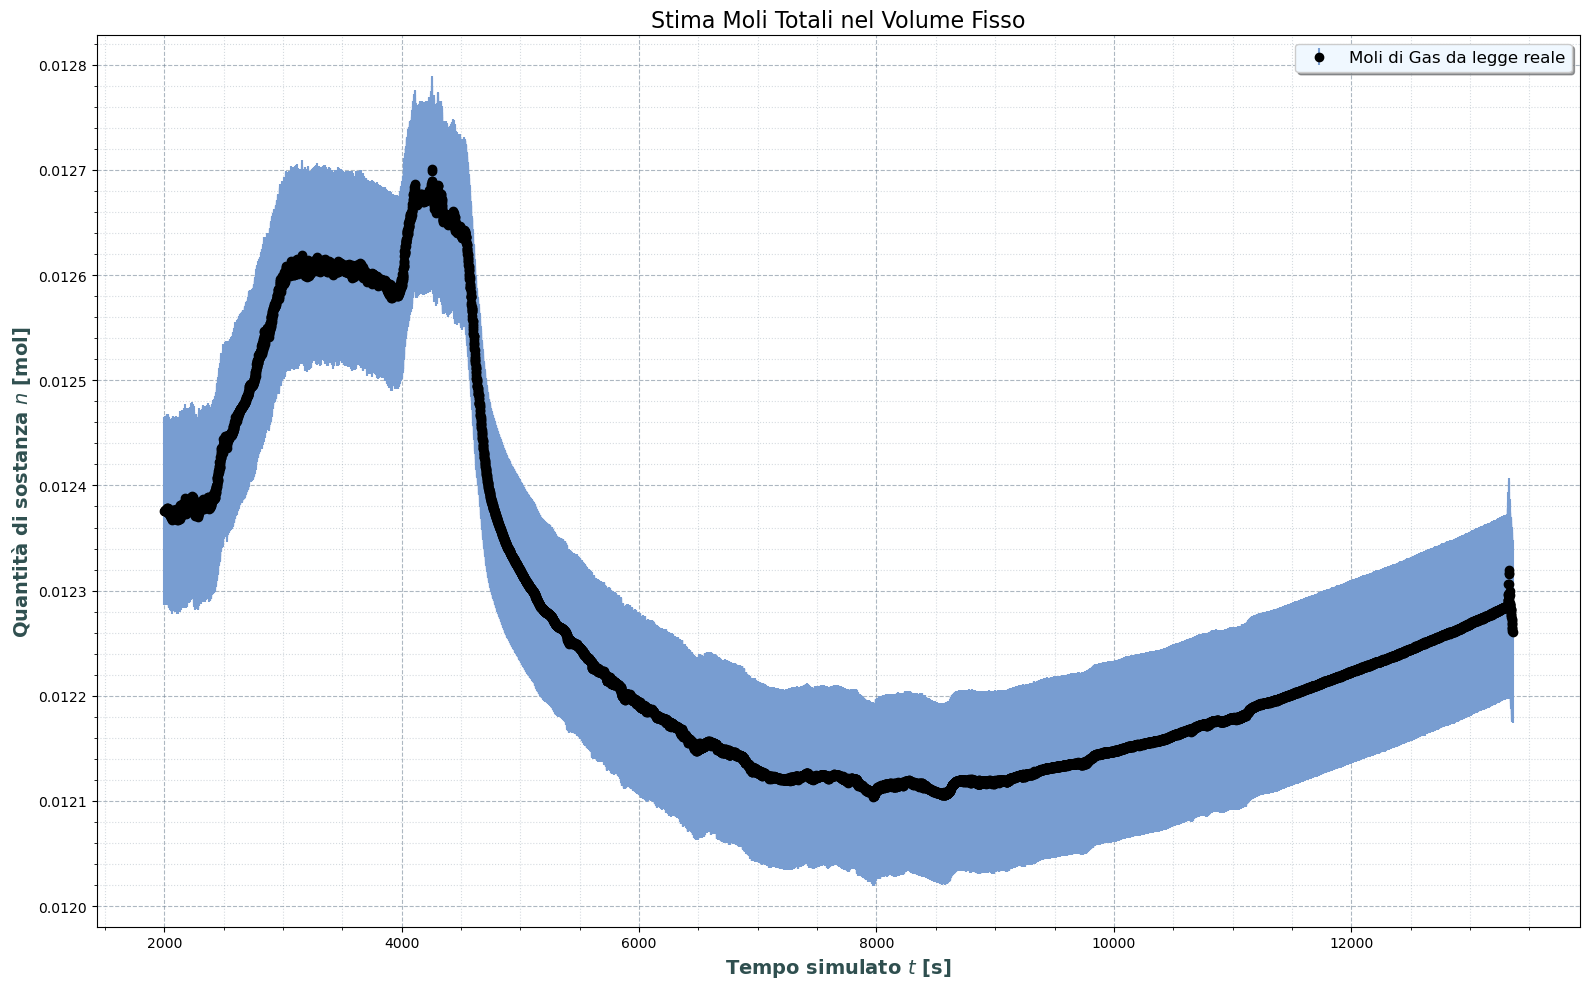

In [5]:

fig, ax1 = plt.subplots(figsize=(16, 10))

ax1.errorbar(x=df['Tempo_Simulato_s'], 
             y=df_risultati['Moli'], 
             yerr=df_risultati['Err_Moli'],   
             fmt='o',                 
             color="#000000",         
             ecolor="#789DD1",                     
             label=r'Moli di Gas da legge reale')

# Formattazione (Stile richiesto)
ax1.set_xlabel(r'Tempo simulato $t$ [s]', fontsize=14, fontweight='bold', color='#2F4F4F')
ax1.set_ylabel(r'Quantità di sostanza $n$ [mol]', fontsize=14, fontweight='bold', color='#2F4F4F')
ax1.set_title(r'Stima Moli Totali nel Volume Fisso', fontsize=16)

# Griglia personalizzata
ax1.grid(True, which='major', linestyle='--', alpha=0.6, color='#778899') 
ax1.minorticks_on()
ax1.grid(True, which='minor', linestyle=':', alpha=0.3, color='#778899')

# Legenda
ax1.legend(loc='upper right', frameon=True, shadow=True, fontsize=12, facecolor='#F0F8FF') 

plt.tight_layout()
plt.show()

In [6]:
# media pesata di n

weights = 1 / (df_risultati['Err_Moli'] ** 2)
weighted_mean = np.sum(df_risultati['Moli'] * weights) / np.sum(weights)
weighted_std = np.sqrt(1 / np.sum(weights))   
print(f"Media pesata delle moli: {weighted_mean:.6f} ± {weighted_std:.6e} mol")

print("\n La statistica fa tendere errore da media pesata a 0, uso quindi media semplice per errore \n")

print(f"Media pesata delle moli: {weighted_mean:.6f} ± {df_risultati['Err_Moli'].mean():.6e} mol")

Media pesata delle moli: 0.012266 ± 8.120718e-07 mol

 La statistica fa tendere errore da media pesata a 0, uso quindi media semplice per errore 

Media pesata delle moli: 0.012266 ± 8.659187e-05 mol


In [7]:
from astroML import stats as astroMLstats

def bins_num (X) :

    sigmaG2 = astroMLstats.sigmaG(X) # quantile at 75 - quantile at 25
    binsize = 2.7 * sigmaG2 / (len(X)**(1/3)) #Freedman-Diaconis
    N = (max(X) - min(X))/binsize

    return int(N+2)

In [8]:
P = df['Pressione'] * 1000.0
V = volume_ml * 1e-6 # m^3
n = weighted_mean
u_n = df_risultati['Err_Moli'].mean()
T = df['Temperatura'] + 273.15 
u_P = 100     
u_V *= 1e-6

# R calcolato
R = (P * V) / (n * T)

# Calcolo dell'errore associato ad ogni istanza di R (Propagazione)
# Usiamo la formula delle derivate prime (quadratica per variabili indipendenti)
err_R = R * np.sqrt(
    (u_P /  P)**2 +
    (u_V / V)**2 +
    (u_n / n)**2 +
    (u_T / T)**2
)

# Aggiornamento DataFrame
df_R = pd.DataFrame({
    'R': R,
    'Err_R': err_R, 
})

# 3. Statistiche
mean_R = df_R['R'].mean()
std_R = df_R['R'].std()

In [9]:
#media pesata degli R
weights = 1 / (df_R['Err_R'] ** 2)
weighted_mean_R = np.sum(df_R['R'] * weights) / np.sum(weights)
weighted_std_R = np.sqrt(1 / np.sum(weights))   
print(f"Media pesata di R: {weighted_mean_R:.6f} ± {weighted_std_R:.6e} J/(mol·K)")

# compatibilità con valor vero di R
R_valor_vero = 8.3144621  # J/(mol·K)
diff_valor_vero = abs(weighted_mean_R - R_valor_vero) / weighted_std_R
print(f"Differenza dal valor vero di R in unità di σ: {diff_valor_vero:.4f} σ")

print("\n La statistica fa tendere errore da media pesata a 0, uso quindi media semplice per errore \n")

print(f"Media pesata di R: {weighted_mean_R:.6f} ± {df_R['Err_R'].mean():.6e} J/(mol·K)")
diff_valor_vero = abs(weighted_mean_R - R_valor_vero) / df_R['Err_R'].mean()
print(f"Differenza dal valor vero di R in unità di σ: {diff_valor_vero:.4f} σ")

Media pesata di R: 8.311279 ± 7.787089e-04 J/(mol·K)
Differenza dal valor vero di R in unità di σ: 4.0877 σ

 La statistica fa tendere errore da media pesata a 0, uso quindi media semplice per errore 

Media pesata di R: 8.311279 ± 8.302329e-02 J/(mol·K)
Differenza dal valor vero di R in unità di σ: 0.0383 σ


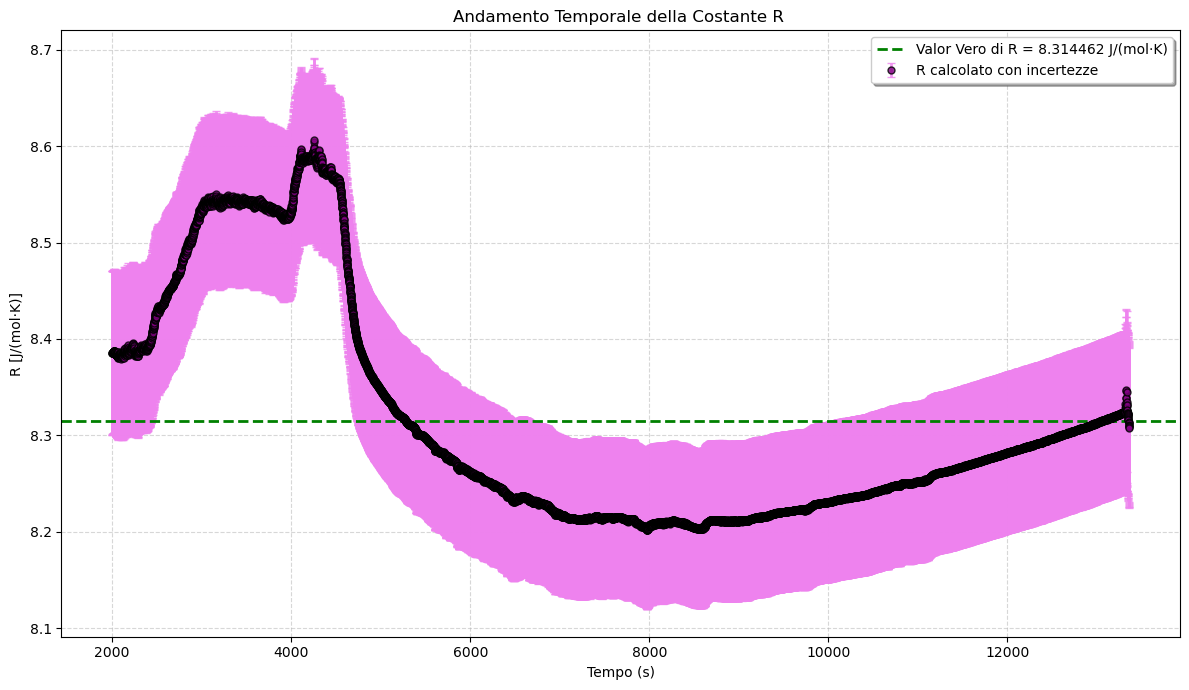

In [10]:
#plot di R con barre d'errore nel tempo
plt.figure(figsize=(12, 7))
plt.errorbar(df['Tempo_Simulato_s'] , df_R['R'], 
             yerr=df_R['Err_R'], 
             fmt='o', markersize=5, markerfacecolor='purple', markeredgecolor='black',
             ecolor='violet', elinewidth=2, capsize=3, alpha=0.8,
             label='R calcolato con incertezze')
plt.title(r'Andamento Temporale della Costante R ')
plt.xlabel('Tempo (s)')
plt.ylabel('R [J/(mol·K)]')
#LINEA ORIZZONTALE AL VALORE VERO DI R
plt.axhline(R_valor_vero, color='green', linestyle='dashed', linewidth=2, 
            label=f'Valor Vero di R = {R_valor_vero:.6f} J/(mol·K)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()  

In [11]:
# -----------------------------------------------------------
# 1. DEFINIZIONE MANUALE DELLA TABELLA (A 101.325 kPa)
# -----------------------------------------------------------
# Righe: Temperatura [°C]
# Colonne: Umidità Relativa [%]
# Valori: Densità [kg/m^3]
dati_tabella = {
    0:   [1.292, 1.291, 1.290, 1.289, 1.288, 1.287],  # T = 0°C
    10:  [1.247, 1.246, 1.246, 1.245, 1.244, 1.243],  # T = 10°C
    20:  [1.204, 1.203, 1.202, 1.201, 1.200, 1.199],  # T = 20°C
    30:  [1.164, 1.163, 1.161, 1.160, 1.158, 1.156],  # T = 30°C
    40:  [1.127, 1.125, 1.122, 1.119, 1.116, 1.113],  # T = 40°C
    50:  [1.092, 1.089, 1.085, 1.081, 1.077, 1.073],  # T = 50°C
    60:  [1.060, 1.056, 1.051, 1.046, 1.041, 1.036],  # T = 60°C
    70:  [1.029, 1.024, 1.018, 1.012, 1.006, 1.000],  # T = 70°C
}

# Creazione DataFrame (Indice=UR, Colonne=T per comodità di lettura, poi trasponiamo)
# Qui definisci gli assi della tua tabella
assi_ur = [0, 20, 40, 60, 80, 100]  # Le colonne dell'UR nella tabella sopra
assi_t  = [0, 10, 20, 30, 40, 50, 60, 70] # Le righe della T

df_tabella = pd.DataFrame(dati_tabella, index=assi_ur) 
# Ora df_tabella ha: Righe=UR, Colonne=Temperatura. 
# Si usa .loc[UR, T]

# -----------------------------------------------------------
# 2. FUNZIONE DI RICERCA (NEAREST NEIGHBOR)
# -----------------------------------------------------------
def get_densita_manuale(p_kpa, t_c, ur_pct, tabella_df):
    """
    1. Trova T e UR più vicini nella tabella.
    2. Legge la densità base.
    3. Scala per la pressione misurata.
    """
    
    # A. Trova l'indice (UR) più vicino disponibile
    # Calcola la differenza assoluta tra l'input e tutti gli indici disponibili
    idx_ur = (np.abs(tabella_df.index - ur_pct)).argmin()
    ur_vicino = tabella_df.index[idx_ur]
    
    # B. Trova la colonna (T) più vicina disponibile
    # Attenzione: i nomi delle colonne devono essere numeri (int/float)
    cols_t = np.array(tabella_df.columns, dtype=float)
    idx_t = (np.abs(cols_t - t_c)).argmin()
    t_vicino = tabella_df.columns[idx_t]
    
    # C. Estrazione valore base (a 101.325 kPa)
    rho_base = tabella_df.loc[ur_vicino, t_vicino]
    
    # D. Correzione per la Pressione Reale (Legge dei Gas)
    # rho_reale = rho_tabella * (P_misurata / P_riferimento_tabella)
    rho_finale = rho_base * (p_kpa / 101.325)
    
    return rho_finale


rho = df.apply(lambda row: get_densita_manuale(
                                row['Pressione'], 
                                row['Temperatura'], 
                                row['Umidita'], 
                                df_tabella
                            ), axis=1)

P_sat_Pa = 611.2 * np.exp((17.67 * df['Temperatura']) / (df['Temperatura'] + 243.5))
P_sat_kpa = P_sat_Pa / 1000.0

# Frazione molare vapore
# P_vapore = ur * P_sat / 100
P_vapore = df['Umidita'] * P_sat_kpa / 100.0
x_v = P_vapore / df['Pressione']

# Stima MM_mix
MM_aria = 0.02897
MM_vapore = 0.018016
MM_mix = (1 - x_v) * MM_aria + x_v * MM_vapore

# Calcolo delle moli
moli_da_densita = (rho * (volume_ml * 1e-6)) / MM_mix 
print(f"\nStima moli da densità tabellata: {moli_da_densita.mean():.6f} mol")



Stima moli da densità tabellata: 0.012277 mol


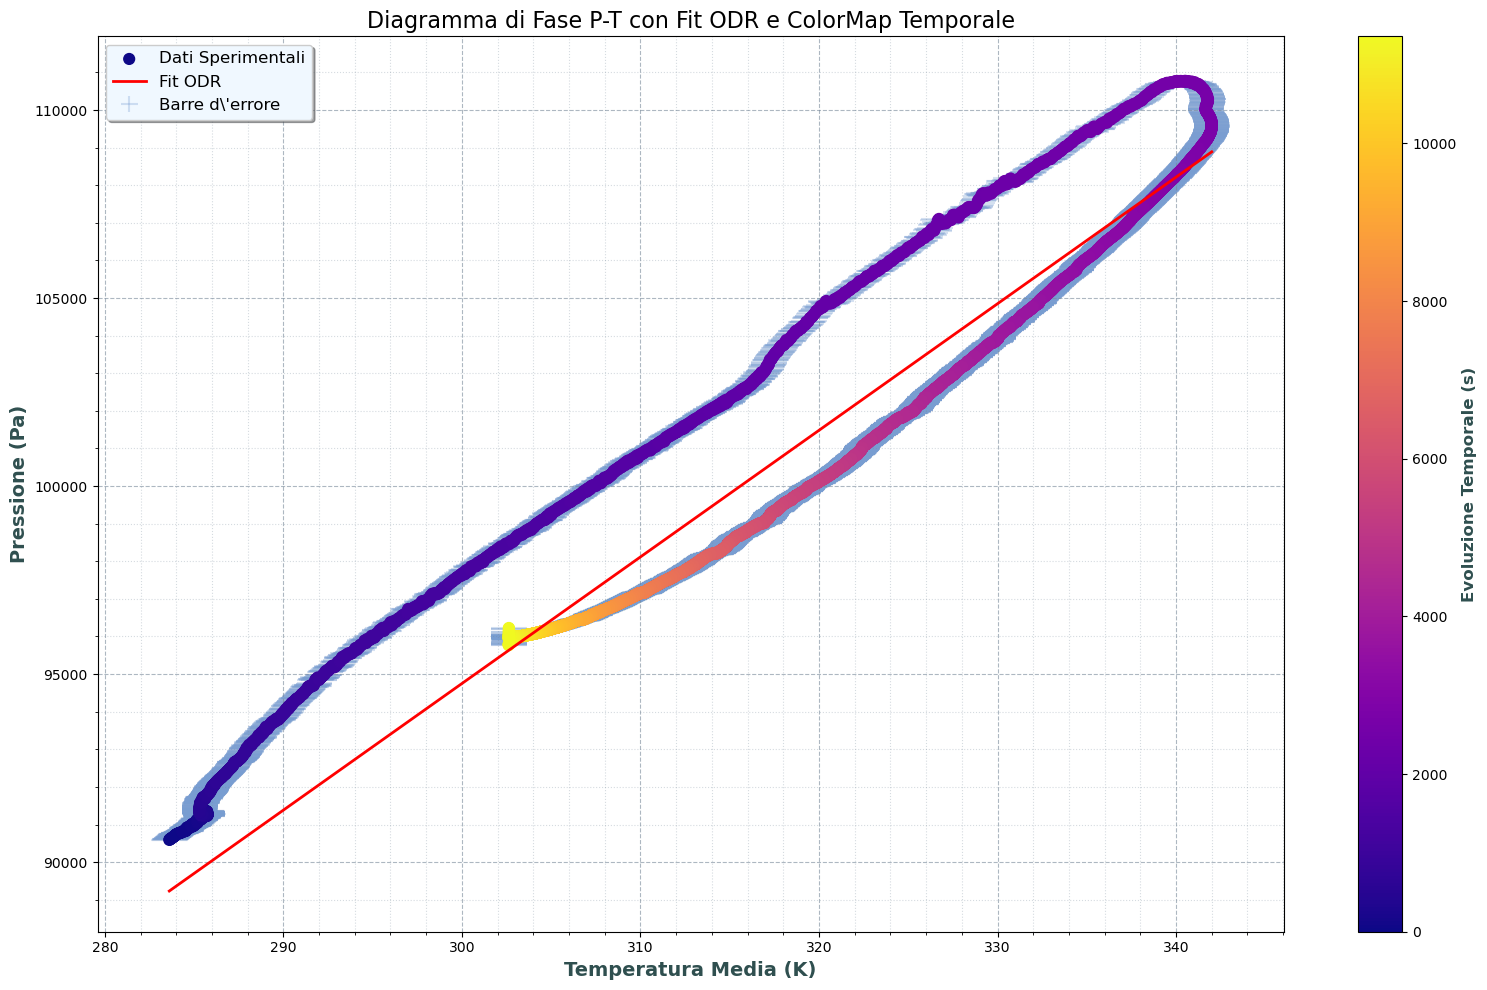

------------------------------
PARAMETRI FIT ODR (y = mx + q)
------------------------------
Pendenza (m)    : 336.6650 ± 0.2518 Pa/K
Intercetta Y (q): -6250.4428 ± 78.9071 Pa
------------------------------
Temperatura a P=0:
T(P=0) = 18.57 ± 1.02 K
------------------------------
Compatibilità con 0 K: 18.13 σ


In [12]:
from scipy import odr

### 1. Preparazione Dati
# Assumo che 'df' sia già caricato e ordinato temporalmente
df_PT = df[['Pressione', 'Temperatura']].copy() #.groupby('Temperatura', as_index=False).mean()

# Definisco x (Temp) e y (Press)
x = df_PT['Temperatura'].values + 273.15  # K
y = df_PT['Pressione'].values * 1000.0    # Pa

# Creo un vettore per la mappatura temporale (indice progressivo)
time_evolution = np.arange(len(x))

### 2. Configurazione ODR
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])
my_data = odr.RealData(x, y, sx=1.0, sy=100.0) # Incertezze costanti
my_odr = odr.ODR(my_data, linear_model, beta0=[1, 90])

# Eseguo il fit
output = my_odr.run()

### 3. Analisi Incertezze e Covarianza
cov_matrix = output.cov_beta

# Logica utente: se Chi2 ridotto < 1, riscalo per ripristinare errori strumentali
if output.res_var < 1.0:
    print(f"Fit 'pulito' (Chi2 ridotto = {output.res_var:.4f}). Riscalo covarianza.")
    cov_matrix = output.cov_beta / output.res_var

m, q = output.beta
sm = np.sqrt(cov_matrix[0, 0])
sq = np.sqrt(cov_matrix[1, 1])

# Calcolo T allo zero assoluto di pressione (Intercetta X)
T0 = -q / m

# Propagazione errore su T0
deriv_q = -1 / m
deriv_m = q / (m**2)
var_T0 = (deriv_q**2 * cov_matrix[1, 1] + 
          deriv_m**2 * cov_matrix[0, 0] + 
          2 * deriv_q * deriv_m * cov_matrix[0, 1])
sT0 = np.sqrt(var_T0)

### 4. Plotting (Stile Unificato)
fig, ax = plt.subplots(figsize=(16, 10))

# A. Barre d'errore (senza marcatori, solo linee)
ax.errorbar(x, y, xerr=1.0, yerr=100.0, fmt='none', 
             ecolor='#789DD1',    
             elinewidth=1.5,       
             alpha=0.3,            
             zorder=1,
             label=r'Barre d\'errore')

# B. Punti colorati con Colormap Plasma (Evoluzione Temporale)
sc = ax.scatter(x, y, c=time_evolution, cmap='plasma', 
                s=60,          # Aumentato leggermente la dimensione
                alpha=1.0,     # Opacità piena per vedere bene il colore
                zorder=2, 
                label='Dati Sperimentali')

# C. Retta di fit ODR
x_fit = np.linspace(min(x), max(x), 100)
y_fit = m * x_fit + q
ax.plot(x_fit, y_fit, color='red', linewidth=2, zorder=3, label='Fit ODR')

# D. Colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Evoluzione Temporale (s)', fontsize=12, fontweight='bold', color='#2F4F4F')

# Formatting richiesto
ax.set_title('Diagramma di Fase P-T con Fit ODR e ColorMap Temporale', fontsize=16)
ax.set_xlabel('Temperatura Media (K)', fontsize=14, fontweight='bold', color='#2F4F4F')
ax.set_ylabel('Pressione (Pa)', fontsize=14, fontweight='bold', color='#2F4F4F')

# Griglia personalizzata
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.6, color='#778899')
ax.grid(which='minor', linestyle=':', alpha=0.3, color='#778899')

# Legenda personalizzata
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=12, facecolor='#F0F8FF')

plt.tight_layout()
plt.show()

### 5. Risultati Numerici
sigma_syst_T = 1.0 
sT0_total = np.sqrt(sT0**2 + sigma_syst_T**2)

print("-" * 30)
print("PARAMETRI FIT ODR (y = mx + q)")
print("-" * 30)
print(f"Pendenza (m)    : {m:.4f} ± {sm:.4f} Pa/K")
print(f"Intercetta Y (q): {q:.4f} ± {sq:.4f} Pa")
print("-" * 30)
print(f"Temperatura a P=0:")
print(f"T(P=0) = {T0:.2f} ± {sT0_total:.2f} K")
print("-" * 30)

zero_assoluto = 0
diff = abs(T0 - zero_assoluto)
comp = diff / sT0_total
print(f"Compatibilità con 0 K: {comp:.2f} σ")


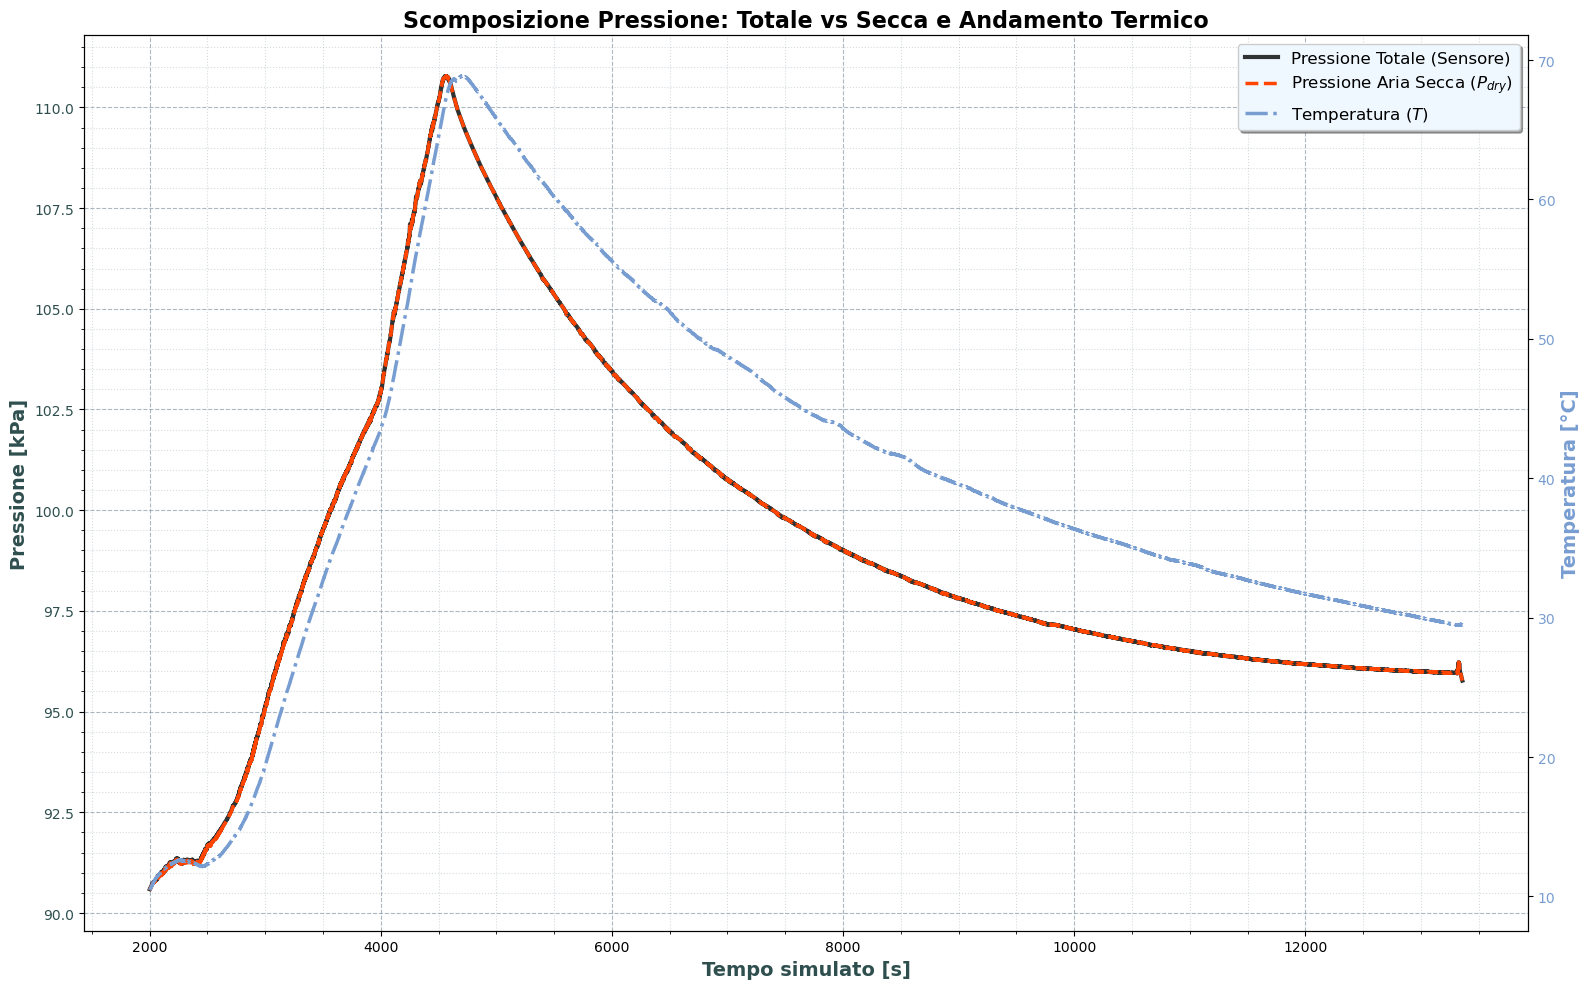

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. FUNZIONI E CALCOLI ---

# Formula di Magnus per P_sat (in Pascal)
def get_sat_vapor_pressure_pa(T_celsius):
    return 611.2 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))

# 1. Calcolo Pressione di Saturazione (Pa) e Pressione Vapore (Pa)
P_sat_pa = get_sat_vapor_pressure_pa(df['Temperatura'])
P_vap_pa = P_sat_pa * (df['Umidita'] / 100.0)

# 2. Conversione in kPa per il grafico
P_vap_kpa = P_vap_pa / 1000.0
P_tot_kpa = df['Pressione'] # Assumiamo sia già in kPa dal caricamento

# 3. Calcolo Pressione Aria Secca (P_tot - P_vap)
P_dry_kpa = P_tot_kpa - P_vap_kpa

# --- 2. PLOTTING (Tripla Variabile) ---
fig, ax1 = plt.subplots(figsize=(16, 10))

# --- ASSE Y SINISTRO: PRESSIONI ---
# A. Pressione Totale (Sensore)
ln1 = ax1.plot(df['Tempo_Simulato_s'], P_tot_kpa, 
         color='#000000', linewidth=3, alpha=0.8, label='Pressione Totale (Sensore)')

# B. Pressione Aria Secca (Componente N2 + O2)
ln2 = ax1.plot(df['Tempo_Simulato_s'], P_dry_kpa, 
         color='#FF4500', linewidth=2.5, linestyle='--', label='Pressione Aria Secca ($P_{dry}$)')

# --- ASSE Y DESTRO: TEMPERATURA ---
ax2 = ax1.twinx() 
ln3 = ax2.plot(df['Tempo_Simulato_s'], df['Temperatura'], 
         color='#789DD1', linewidth=2.5, linestyle='-.', label='Temperatura ($T$)')

# --- CONFIGURAZIONE STILE ---
ax1.set_xlabel('Tempo simulato [s]', fontsize=14, fontweight='bold', color='#2F4F4F')
ax1.set_ylabel('Pressione [kPa]', fontsize=14, fontweight='bold', color='#2F4F4F')
ax2.set_ylabel('Temperatura [°C]', fontsize=14, fontweight='bold', color='#789DD1')

ax1.tick_params(axis='y', labelcolor='#2F4F4F')
ax2.tick_params(axis='y', labelcolor='#789DD1')

ax1.set_title('Scomposizione Pressione: Totale vs Secca e Andamento Termico', fontsize=16, fontweight='bold')

# Griglia (sull'asse principale)
ax1.grid(True, which='major', linestyle='--', alpha=0.6, color='#778899')
ax1.minorticks_on()
ax1.grid(True, which='minor', linestyle=':', alpha=0.3, color='#778899')

# Legenda Unificata
lines = ln1 + ln2 + ln3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', frameon=True, shadow=True, fontsize=12, facecolor='#F0F8FF')

# Riempimento per evidenziare la componente di vapore (Differenza tra Totale e Secca)
ax1.fill_between(df['Tempo_Simulato_s'], P_tot_kpa, P_dry_kpa,
                 color='#87CEEB', alpha=0.2, label='Contributo Vapore Acqueo')

plt.tight_layout()
plt.show()


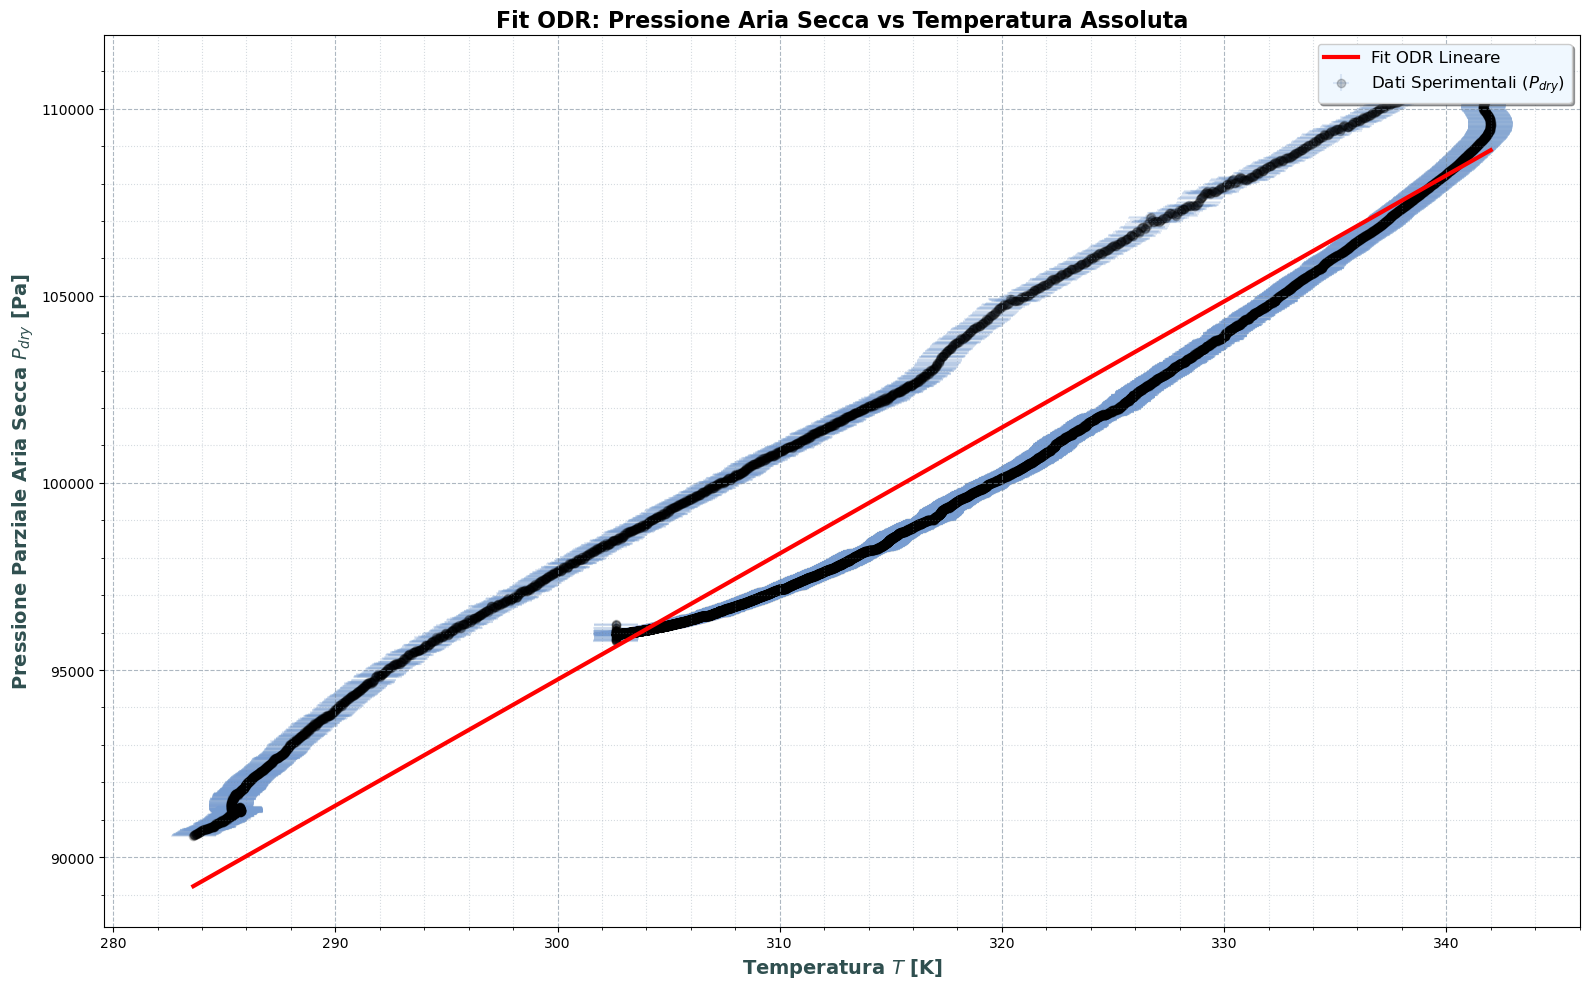

RISULTATI FIT ODR (P_dry vs T_kelvin)
----------------------------------------
Pendenza (m)    : 336.8685 ± 0.2519 Pa/K
Intercetta (q)  : -6316.90 ± 78.93 Pa
----------------------------------------
Temperatura allo Zero di Pressione (T0):
Valore Calcolato: 18.75 ± 1.02 K
Valore Atteso   : 0.00 K
----------------------------------------
Compatibilità con Zero Assoluto: 18.31 σ


In [14]:

# Definizione variabili per il fit
# x = T (Kelvin), y = P_dry (Pascal)
x = df['Temperatura'].values + 273.15 
y = P_dry_kpa.values * 1000.0

# Incertezze Strumentali
sx_err = 1.0   # 1 K (incertezza temperatura)
sy_err = 100.0 # 100 Pa (incertezza pressione)

# --- 2. ESECUZIONE FIT ODR ---
# Modello Lineare: y = m*x + q
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])

# Data Object con errori costanti
my_data = odr.RealData(x, y, sx=sx_err, sy=sy_err)

# Inizializzazione ODR
my_odr = odr.ODR(my_data, linear_model, beta0=[300, 0])

# Run Fit
output = my_odr.run()

# --- 3. ANALISI ERRORI E RISULTATI ---
cov_matrix = output.cov_beta

# Controllo bontà del fit (Res variance)
# Se il fit è troppo "pulito" (Chi2 ridotto < 1), ripristiniamo la scala degli errori
if output.res_var < 1.0:
    print(f"Fit troppo 'pulito' (Chi2 ridotto = {output.res_var:.4f}). Uso covarianza originale.")
    # In ODR output.cov_beta è già scalato per res_var, quindi per tornare agli errori puri bisognerebbe dividere.
    # Ma se res_var < 1, significa che gli errori dati erano sovrastimati rispetto allo scatter dei dati.
    # Spesso si mantiene cov_beta così com'è o si forza res_var=1 per stime conservative.
    # Qui manteniamo la logica del tuo snippet:
    cov_matrix = output.cov_beta / output.res_var 
else:
    # Se il fit è rumoroso (res_var > 1), la covarianza è già scalata correttamente per riflettere lo scatter reale.
    pass

m, q = output.beta
sm = np.sqrt(cov_matrix[0, 0])
sq = np.sqrt(cov_matrix[1, 1])
cov_mq = cov_matrix[0, 1]

# Calcolo Zero Assoluto (T0 = -q/m)
T0 = -q / m

# Propagazione errore su T0 (Formula completa con covarianza)
deriv_q = -1 / m
deriv_m = q / (m**2)

var_T0 = (deriv_q**2 * cov_matrix[1, 1] + 
          deriv_m**2 * cov_matrix[0, 0] + 
          2 * deriv_q * deriv_m * cov_mq)

sT0 = np.sqrt(var_T0)

# Aggiunta errore sistematico su T (accuratezza termometro)
sigma_syst_T = 1.0 
sT0_total = np.sqrt(sT0**2 + sigma_syst_T**2)

# --- 4. PLOTTING ---
plt.figure(figsize=(16, 10))

# Dati Sperimentali
plt.errorbar(x, y, xerr=sx_err, yerr=sy_err, fmt='o', 
             color='#000000',     
             ecolor='#789DD1',    
             elinewidth=1.5,       
             alpha=0.2,            
             label=r'Dati Sperimentali ($P_{dry}$)',
             zorder=1)

# Retta di Fit
x_fit = np.linspace(min(x), max(x), 100)
y_fit = m * x_fit + q

plt.plot(x_fit, y_fit, color='red', linewidth=3, label='Fit ODR Lineare', zorder=10)

# Decorazioni
plt.title(r'Fit ODR: Pressione Aria Secca vs Temperatura Assoluta', fontsize=16, fontweight='bold')
plt.ylabel(r'Pressione Parziale Aria Secca $P_{dry}$ [Pa]', fontsize=14, fontweight='bold', color='#2F4F4F')
plt.xlabel(r'Temperatura $T$ [K]', fontsize=14, fontweight='bold', color='#2F4F4F')

# Griglia
plt.grid(True, which='major', linestyle='--', alpha=0.6, color='#778899')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', alpha=0.3, color='#778899')

# Legenda
plt.legend(loc='upper right', frameon=True, shadow=True, fontsize=12, facecolor='#F0F8FF')

plt.tight_layout()
plt.show()

# --- 5. RISULTATI E VERIFICHE ---

print("RISULTATI FIT ODR (P_dry vs T_kelvin)")
print("-" * 40)
print(f"Pendenza (m)    : {m:.4f} ± {sm:.4f} Pa/K")
print(f"Intercetta (q)  : {q:.2f} ± {sq:.2f} Pa")
print("-" * 40)
print(f"Temperatura allo Zero di Pressione (T0):")
print(f"Valore Calcolato: {T0:.2f} ± {sT0_total:.2f} K")
print(f"Valore Atteso   : 0.00 K")
print("-" * 40)

# Verifica compatibilità
diff_T0_zero = abs(T0 - 0.0)
comp_zero = diff_T0_zero / sT0_total
print(f"Compatibilità con Zero Assoluto: {comp_zero:.2f} σ")

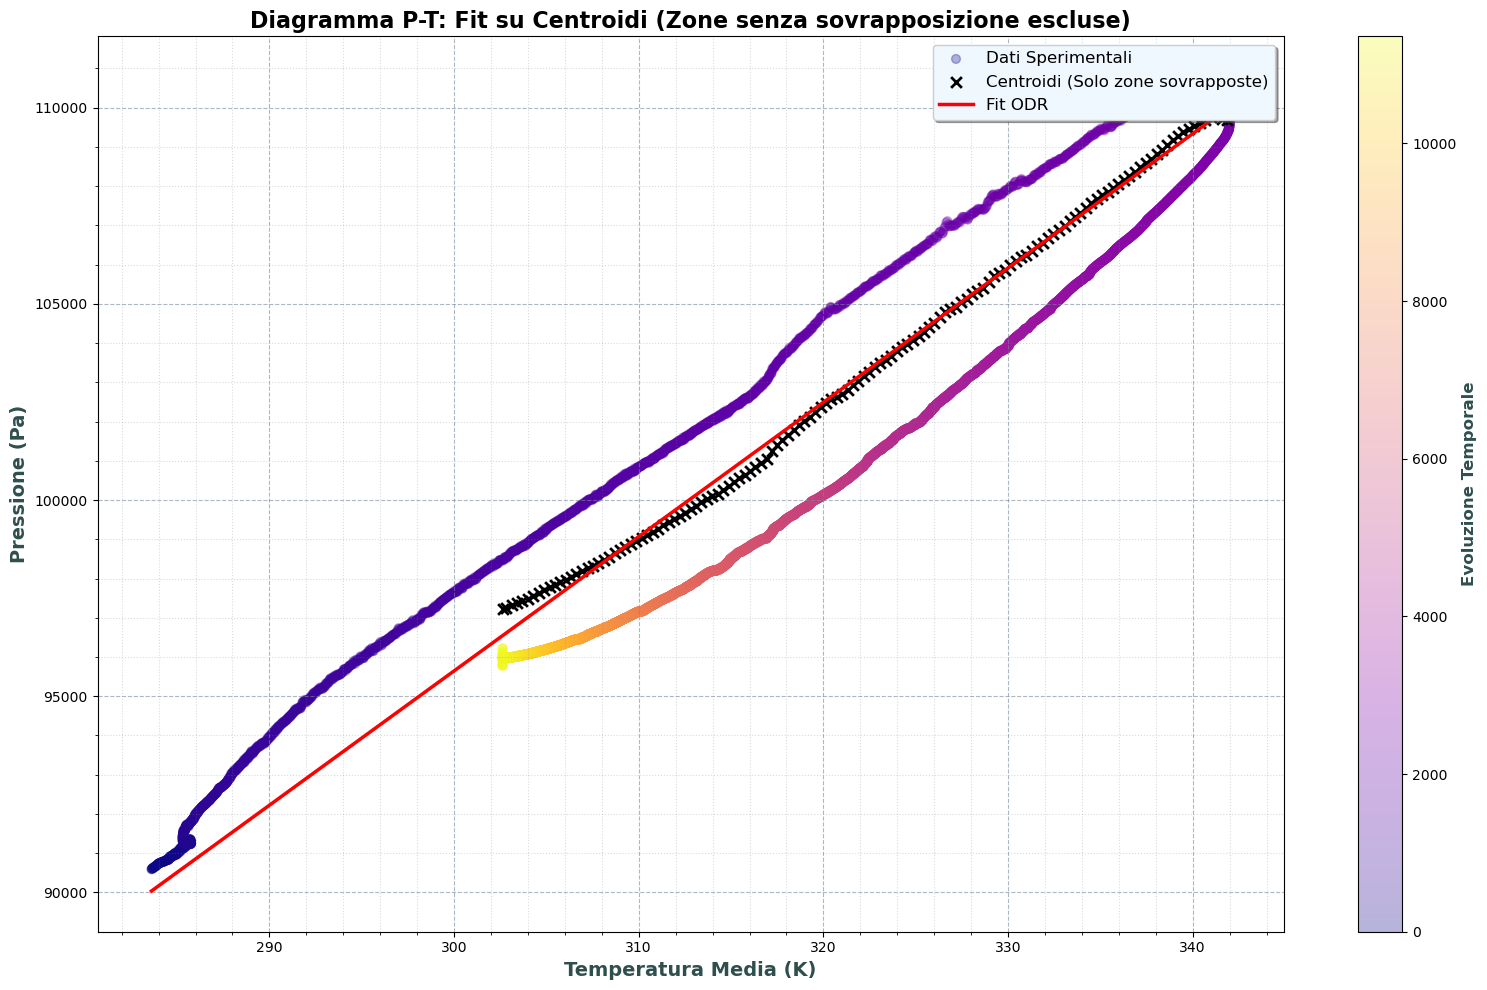

------------------------------
PARAMETRI FIT (Zone sovrapposte)
------------------------------
Pendenza (m)   : 342.2088 ± 4.3951 Pa/K
Intercetta (q) : -7016.7694 ± 1416.9692 Pa
------------------------------
Zero Assoluto  : 20.50 ± 4.00 K
------------------------------


In [15]:

### 1. Preparazione Dati e Separazione Rami
df_PT = df[['Pressione', 'Temperatura']].copy()

# Dati grezzi
x_all = df_PT['Temperatura'].values + 273.15 
y_all = df_PT['Pressione'].values * 1000.0   
time_idx = np.arange(len(x_all))

# Trovo il punto di inversione termica (Massimo T)
idx_peak = np.argmax(x_all)

# Separo gli indici in due insiemi: Andata (Heating) e Ritorno (Cooling)
idx_heat = np.arange(0, idx_peak + 1)
idx_cool = np.arange(idx_peak + 1, len(x_all))

### 2. Algoritmo di Binning con Verifica Bilaterale
num_bins = 200
bins = np.linspace(min(x_all), max(x_all), num_bins)

x_collapsed = []
y_collapsed = []

for i in range(len(bins) - 1):
    # Definizione bin corrente
    t_min, t_max = bins[i], bins[i+1]
    
    # Maschere per identificare i punti in questo bin
    mask_in_bin = (x_all >= t_min) & (x_all < t_max)
    
    # Intersezione: Punti nel bin E nel ramo riscaldamento
    mask_heat_bin = mask_in_bin & (np.isin(time_idx, idx_heat))
    
    # Intersezione: Punti nel bin E nel ramo raffreddamento
    mask_cool_bin = mask_in_bin & (np.isin(time_idx, idx_cool))
    
    # CONDIZIONE RIGIDA: Procedo solo se ENTRAMBI i rami hanno punti nel bin
    if np.sum(mask_heat_bin) > 0 and np.sum(mask_cool_bin) > 0:
        
        # Calcolo le medie separate (per evitare bias di densità)
        y_mean_heat = np.mean(y_all[mask_heat_bin])
        y_mean_cool = np.mean(y_all[mask_cool_bin])
        
        # La pressione media è la media aritmetica tra i due rami
        y_avg = (y_mean_heat + y_mean_cool) / 2.0
        
        # La temperatura x è il centro del bin (o la media dei punti, qui uso media punti)
        x_avg = np.mean(x_all[mask_in_bin])
        
        x_collapsed.append(x_avg)
        y_collapsed.append(y_avg)

# Converto in array per il fit
x_fit_data = np.array(x_collapsed)
y_fit_data = np.array(y_collapsed)

### 3. Fit ODR sui dati filtrati e centrati
linear_model = odr.Model(lambda B, x: B[0]*x + B[1])
my_data = odr.RealData(x_fit_data, y_fit_data, sx=1.0, sy=100.0) 
my_odr = odr.ODR(my_data, linear_model, beta0=[1, 90])
output = my_odr.run()

m, q = output.beta
cov_matrix = output.cov_beta
if output.res_var < 1.0:
    cov_matrix = output.cov_beta / output.res_var

sm = np.sqrt(cov_matrix[0, 0])
sq = np.sqrt(cov_matrix[1, 1])

# Zero Assoluto
T0 = -q / m
# Errore T0
deriv_q = -1 / m
deriv_m = q / (m**2)
var_T0 = (deriv_q**2 * cov_matrix[1, 1] + 
          deriv_m**2 * cov_matrix[0, 0] + 
          2 * deriv_q * deriv_m * cov_matrix[0, 1])
sT0_total = np.sqrt(var_T0 + 1.0**2)

### 4. Plotting
fig, ax = plt.subplots(figsize=(16, 10))

# A. Dati Originali (Background)
sc = ax.scatter(x_all, y_all, c=time_idx, cmap='plasma', 
                s=40, alpha=0.3, zorder=1, label='Dati Sperimentali')

# B. Dati "Collassati" (Media geometrica pura)
ax.scatter(x_fit_data, y_fit_data, color='black', marker='x', 
           s=60, linewidth=2, zorder=2, label='Centroidi (Solo zone sovrapposte)')

# C. Retta di Fit
x_line = np.linspace(min(x_all), max(x_all), 100)
y_line = m * x_line + q
ax.plot(x_line, y_line, color='red', linewidth=2.5, zorder=3, label='Fit ODR')

# Formatting
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Evoluzione Temporale', fontsize=12, fontweight='bold', color='#2F4F4F')

ax.set_title('Diagramma P-T: Fit su Centroidi (Zone senza sovrapposizione escluse)', fontsize=16, fontweight='bold')
ax.set_xlabel('Temperatura Media (K)', fontsize=14, fontweight='bold', color='#2F4F4F')
ax.set_ylabel('Pressione (Pa)', fontsize=14, fontweight='bold', color='#2F4F4F')
ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=12, facecolor='#F0F8FF')

ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.6, color='#778899')
ax.grid(which='minor', linestyle=':', alpha=0.3, color='#778899')

plt.tight_layout()
plt.show()

### 5. Risultati
print("-" * 30)
print("PARAMETRI FIT (Zone sovrapposte)")
print("-" * 30)
print(f"Pendenza (m)   : {m:.4f} ± {sm:.4f} Pa/K")
print(f"Intercetta (q) : {q:.4f} ± {sq:.4f} Pa")
print("-" * 30)
print(f"Zero Assoluto  : {T0:.2f} ± {sT0_total:.2f} K")
print("-" * 30)